# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

**Файл data_arc_new.csv**
key — номер партии;

Начало нагрева дугой — время начала нагрева;

Конец нагрева дугой — время окончания нагрева;

Активная мощность — значение активной мощности;

Реактивная мощность — значение реактивной мощности.

**Файл data_bulk_new.csv**

key — номер партии;

Bulk 1 … Bulk 15 — объём подаваемого материала.

**Файл data_bulk_time_new.csv**

key — номер партии;

Bulk 1 … Bulk 15 — время подачи материала.

**Файл data_gas_new.csv**

key — номер партии;

Газ 1 — объём подаваемого газа.

**Файл data_temp_new.csv**

key — номер партии;

Время замера — время замера;

Температура — значение температуры.

**Файл data_wire_new.csv**

key — номер партии;

Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

**Файл data_wire_time_new.csv**

key — номер партии;

Wire 1 … Wire 9 — время подачи проволочных материалов.

*Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.*

## Загрузка данных

In [2]:
pip install numpy pandas scikit-learn tensorflow

     |████████████████████████████████| 601.3 MB 4.9 kB/s s eta 0:00:01
     |████████████████████████████████| 294 kB 86.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 77.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 92.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 70.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 71.6 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 82.1 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 87.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 61.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 69.7 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 66.7 MB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.3.0
 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import time

In [4]:
#Функция для первичного просмотра данных
def describer(data):
    print('_'*100)
    print('Общая информация о датасете:')
    print(data.info())
    print('_'*100)
    print('Первые 5 строк:')
    display(data.head())
    print('_'*100)
    display(data.describe())
    print('_'*100)
    print('Информация о пропусках в данных:')
    print(data.isna().sum())
    print('_'*100)
    print('Информация о дубликатах:')
    print(data.duplicated().sum())

**Arc**

In [5]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
describer(arc)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
____________________________________________________________________________________________________
Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


____________________________________________________________________________________________________


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


____________________________________________________________________________________________________
Информация о пропусках в данных:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**Bulk**

In [6]:
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
describer(bulk)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
_____________________

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


____________________________________________________________________________________________________


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


____________________________________________________________________________________________________
Информация о пропусках в данных:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**bulk_time**

In [7]:
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
describer(bulk_time)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
_______________________________________

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


____________________________________________________________________________________________________


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


____________________________________________________________________________________________________
Информация о пропусках в данных:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**gas**

In [8]:
gas = pd.read_csv('/datasets/data_gas_new.csv')
describer(gas)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
____________________________________________________________________________________________________
Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


____________________________________________________________________________________________________


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


____________________________________________________________________________________________________
Информация о пропусках в данных:
key      0
Газ 1    0
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**temp**

In [9]:
temp = pd.read_csv('/datasets/data_temp_new.csv')
describer(temp)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
____________________________________________________________________________________________________
Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


____________________________________________________________________________________________________


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


____________________________________________________________________________________________________
Информация о пропусках в данных:
key                0
Время замера       0
Температура     3427
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**wire**

In [10]:
wire = pd.read_csv('/datasets/data_wire_new.csv')
describer(wire)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
____________________________________________________________________________________________________
Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________________________________________________________________________________


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


____________________________________________________________________________________________________
Информация о пропусках в данных:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**wire_time**

In [11]:
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
describer(wire_time)

____________________________________________________________________________________________________
Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
____________________________________________________________________________________________________
Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________________________________________________________________________________


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


____________________________________________________________________________________________________
Информация о пропусках в данных:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
____________________________________________________________________________________________________
Информация о дубликатах:
0


**Вывод**

- Загрузили все данные.

- Обнаружили пропуски в данных, возможно это говорит об отсутсвии данного материала в производстве, поэтому заменим на "0" эти пропуски.

## Исследовательский анализ и предобработка данных

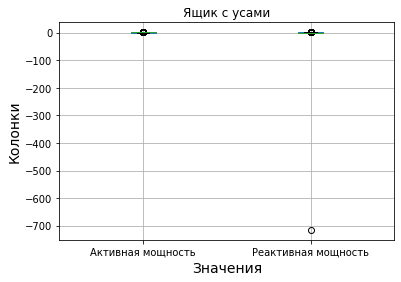

<Figure size 864x432 with 0 Axes>

In [12]:
arc.boxplot(column=['Активная мощность', 'Реактивная мощность'])  
plt.title('Ящик с усами')
plt.xlabel('Значения', fontsize=14)  
plt.ylabel('Колонки', fontsize=14)  
plt.figure(figsize=(12, 6))
plt.show();

Заметим большой выброс в колонке Реактивная мощность, от него стоит избавиться

In [13]:
arc = arc[arc['Реактивная мощность'] > -500]

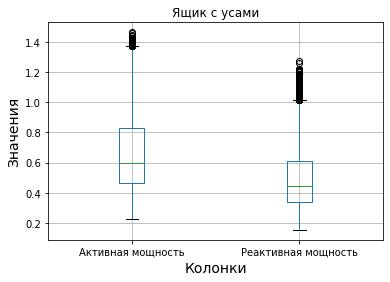

<Figure size 864x432 with 0 Axes>

In [14]:
arc.boxplot(column=['Активная мощность', 'Реактивная мощность'])  
plt.title('Ящик с усами')
plt.xlabel('Колонки', fontsize=14)  
plt.ylabel('Значения', fontsize=14)  
plt.figure(figsize=(12, 6))
plt.show();

Добавим такие признаки как полная мощность и затраты электроэнергии, для этого воспользуемся формулами:

**Полная мощность:**
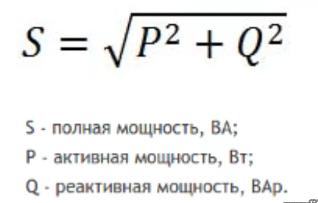

**Затраты электоэнергии:**
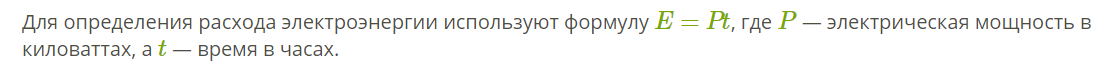

In [15]:
# Преобразование колонок к типу datetime
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

In [16]:
# Расчет полной мощности 
arc['Полная мощность'] = (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**0.5
# Вычисление времени нагрева дугой в секундах
arc['Время нагрева дугой'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds().astype(int)
# Вычисление затрат электроэнергии
arc['Затраты электроэнергии'] = arc['Полная мощность'] * arc['Время нагрева дугой']

In [17]:
# Определение функций агрегаци
agg_funcs = {
    'key': 'count',
    'Начало нагрева дугой': 'min',
    'Конец нагрева дугой': 'max',
    'Активная мощность': 'mean',
    'Реактивная мощность': 'mean',
    'Полная мощность': 'mean',
    'Время нагрева дугой': 'sum',
    'Затраты электроэнергии': 'sum'
}

# Группировка данных и применение агрегирующих функций
arc_summary = arc.groupby('key').agg(agg_funcs).rename(columns={'key':'Количество циклов нагрева'})

In [18]:
arc_summary

,Количество циклов нагрева,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии
key,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,0.743747,1098,770.282114
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,0.647087,811,481.760005
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,1.003845,655,722.837668
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,0.850010,741,683.455597
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,0.704245,869,512.169934
...,...,...,...,...,...,...,...,...
3237,5,2019-09-06 11:31:25,2019-09-06 11:53:55,0.508374,0.405083,0.650131,909,630.503534
3238,3,2019-09-06 12:16:25,2019-09-06 12:31:35,0.458274,0.346034,0.574646,546,286.052252
3239,8,2019-09-06 14:17:00,2019-09-06 15:05:50,0.606001,0.442693,0.751810,1216,941.538764


Построим ящик с усами для колонки с затратами электроэнергии

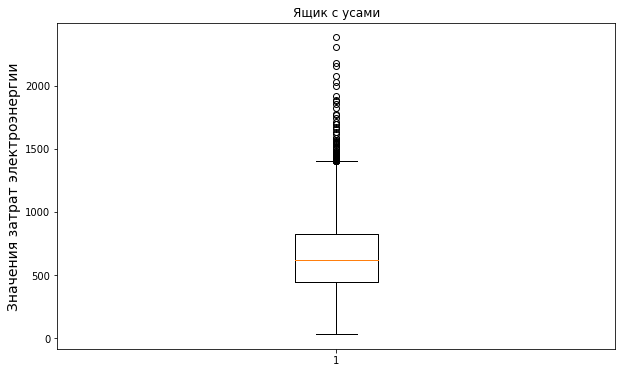

In [19]:
plt.figure(figsize=(10, 6))
arc_summary = arc_summary[arc_summary['Затраты электроэнергии'] < 4000]
plt.boxplot(arc_summary['Затраты электроэнергии'])  
plt.title('Ящик с усами')
plt.ylabel('Значения затрат электроэнергии', fontsize=14)
plt.xlabel('')
plt.show();

видим явный выброс со значением **>4000**, скорее всего приходилось повторять цикл нагрева большое количество раз, для нужного результата. Избавимся от него.

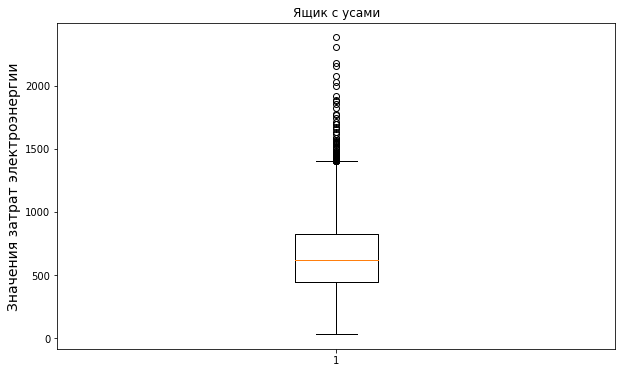

In [20]:
plt.figure(figsize=(10, 6))
arc_summary = arc_summary[arc_summary['Затраты электроэнергии'] < 4000]
plt.boxplot(arc_summary['Затраты электроэнергии'])  
plt.title('Ящик с усами')
plt.ylabel('Значения затрат электроэнергии', fontsize=14)
plt.xlabel('')
plt.show();

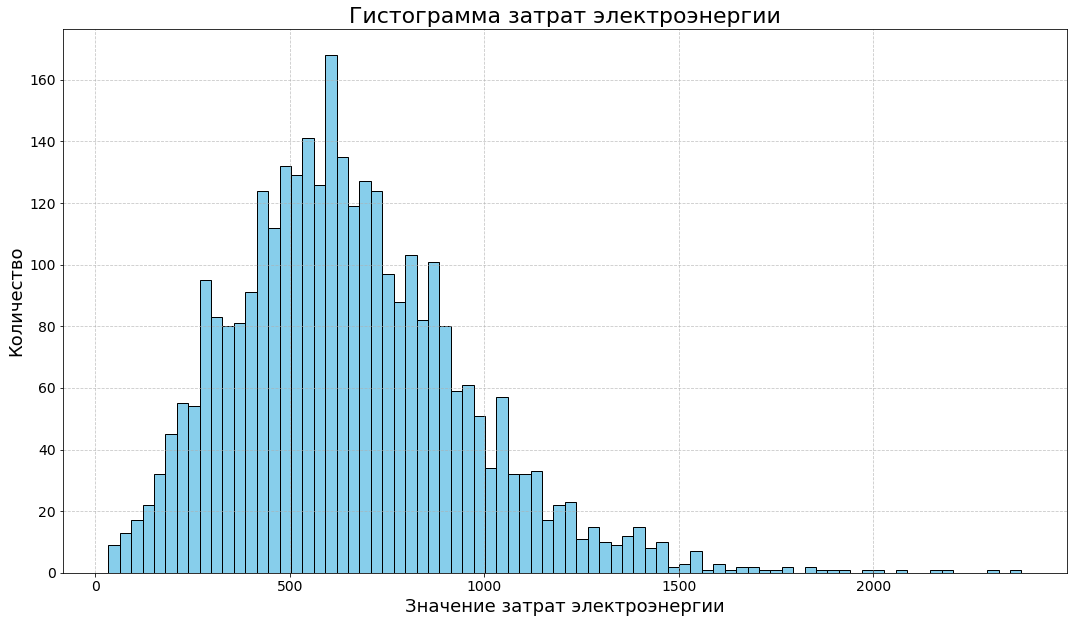

In [21]:
plt.figure(figsize=(18, 10))

plt.hist(arc_summary['Затраты электроэнергии'], bins=80, color='skyblue', edgecolor='black')

plt.title('Гистограмма затрат электроэнергии', fontsize=22)
plt.xlabel('Значение затрат электроэнергии', fontsize=18)
plt.ylabel('Количество', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Теперь перейдем к **bulk**, заполним пропуски нулями, т.к.в местах пропусках данных вероятнее всего, сыпучие материалы не подавались. Добавим столбец с общей суммой добавок этих материалов.

In [22]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [23]:
bulk = bulk.fillna(0)
bulk = bulk.astype(int)
bulk['bulk_sum'] = bulk.sum(axis=1)
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589


Теперь рассмотрим данные с результатами измерения температуры

In [24]:
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [25]:
temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [26]:
temp = temp.fillna(0)
temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

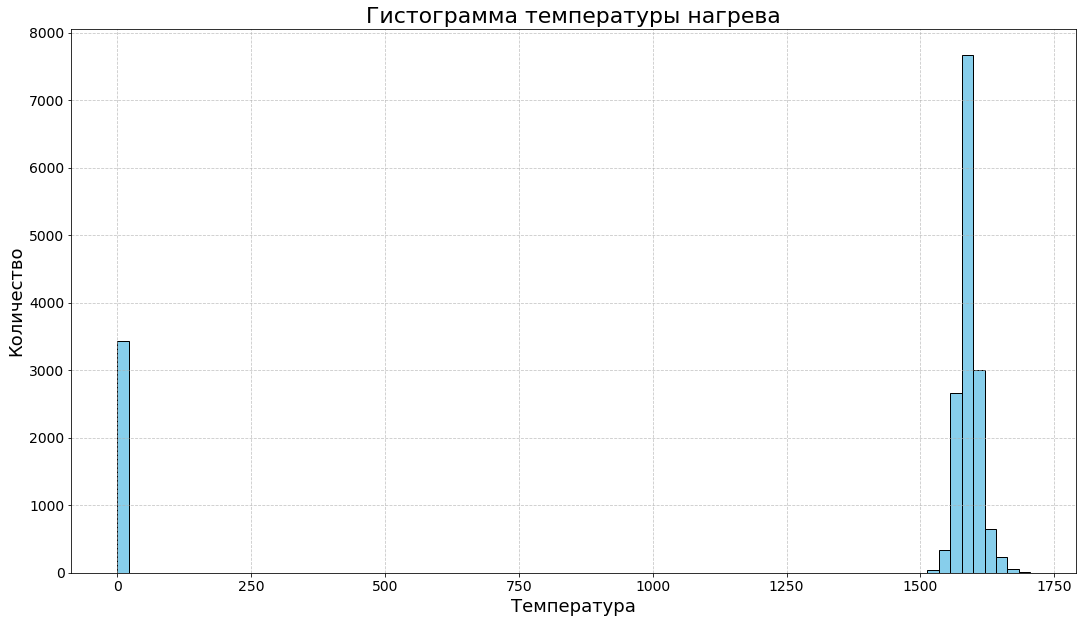

In [27]:
plt.figure(figsize=(18, 10))

plt.hist(temp['Температура'], bins=80, color='skyblue', edgecolor='black')

plt.title('Гистограмма температуры нагрева', fontsize=22)
plt.xlabel('Температура', fontsize=18)
plt.ylabel('Количество', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Сгруппируем данные по key и добавим столбцы с минимальной температурой и конечной

In [28]:
temp = temp.groupby('key').agg(
    Начальная_температура=('Температура', 'first'),
    Минимальная_температура=('Температура', 'min'),
    Конечная_температура=('Температура', 'last')
).reset_index()
temp.head()

,key,Начальная_температура,Минимальная_температура,Конечная_температура
0,1,1571.0,1571.0,1613.0
1,2,1581.0,1577.0,1602.0
2,3,1596.0,1596.0,1599.0
3,4,1601.0,1601.0,1625.0
4,5,1576.0,1576.0,1602.0


Так как по регламенту температура не должна опускаться ниже 1400 градусов, удалим все строки с таким значением в колонке Минимальная температура

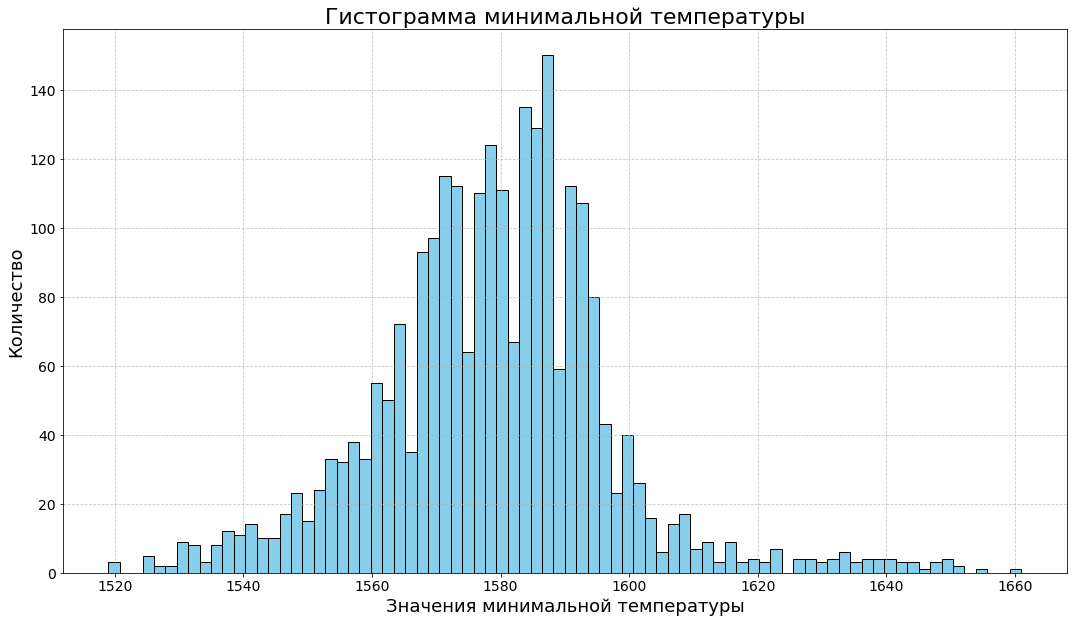

In [29]:
temp = temp[temp['Минимальная_температура'] > 1400]
plt.figure(figsize=(18, 10))

plt.hist(temp['Минимальная_температура'], bins=80, color='skyblue', edgecolor='black')

plt.title('Гистограмма минимальной температуры', fontsize=22)
plt.xlabel('Значения минимальной температуры', fontsize=18)
plt.ylabel('Количество', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [30]:
temp.describe()

,key,Начальная_температура,Минимальная_температура,Конечная_температура
count,2473.000000,2473.000000,2473.000000,2473.000000
mean,1249.664375,1589.016175,1578.854832,1595.338051
std,720.395663,24.996127,18.316249,16.031388
min,1.000000,1519.000000,1519.000000,1541.000000
25%,627.000000,1572.000000,1569.000000,1587.000000
50%,1251.000000,1588.000000,1579.000000,1593.000000
75%,1872.000000,1605.000000,1589.000000,1599.000000
max,2499.000000,1679.000000,1661.000000,1700.000000


In [31]:
temp.isna().sum()

key                        0
Начальная_температура      0
Минимальная_температура    0
Конечная_температура       0
dtype: int64

Колонка - **Конечная_температура** - целевой признак, аномалии и нулевые значения удалили.

Заполним нулями ищмерения в табличке wire:

In [32]:
wire = wire.fillna(0)
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


In [33]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [34]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


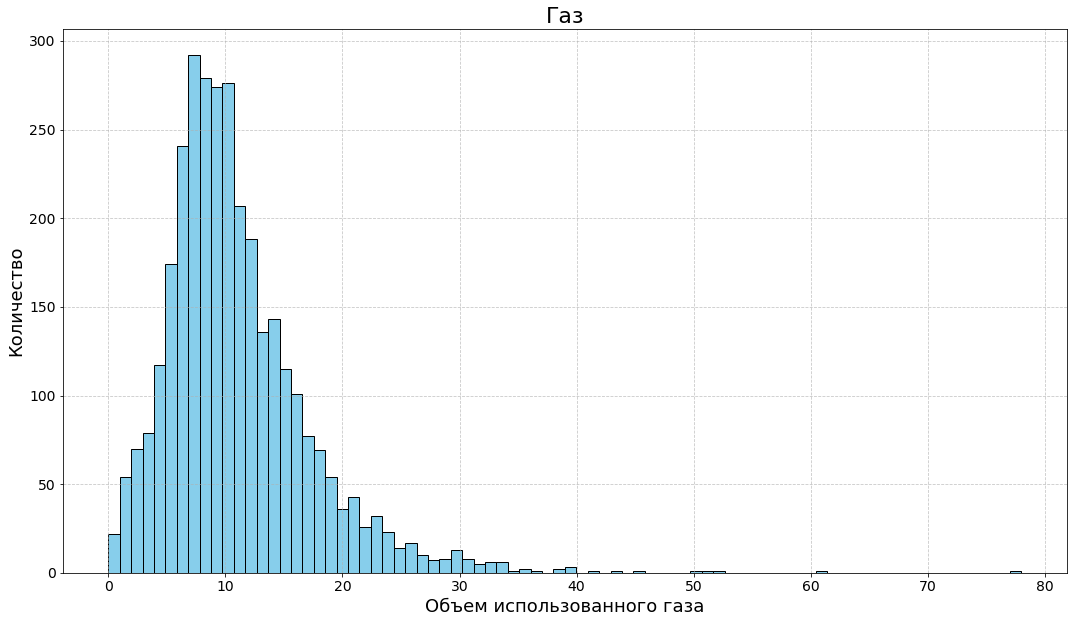

In [35]:
plt.figure(figsize=(18, 10))

plt.hist(gas['Газ 1'], bins=80, color='skyblue', edgecolor='black')

plt.title('Газ', fontsize=22)
plt.xlabel('Объем использованного газа', fontsize=18)
plt.ylabel('Количество', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [36]:
gas[gas['Газ 1'] > 40].sort_values(by='Газ 1')

,key,Газ 1
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
116,117,50.581035
2567,2570,51.380229
2107,2110,52.142373
277,280,60.935689
319,322,77.995040


Сложно сказать откуда появились такие выбросы, поэтому трогать их не будем, возможно для приготовления сплава действительно понадобился такой объем газа

## Объединение данных

Объединим данные по ключу **key**:

In [37]:
all_df = [bulk, gas, temp, wire]
merged_df = arc_summary
for df in all_df:
    merged_df = merged_df.merge(df, on=['key'])
merged_df.head()

,key,Количество циклов нагрева,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии,Bulk 1,...,Конечная_температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,0.743747,1098,770.282114,0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,0.647087,811,481.760005,0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,1.003845,655,722.837668,0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,0.850010,741,683.455597,0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,0.704245,869,512.169934,0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
merged_df

,key,Количество циклов нагрева,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраты электроэнергии,Bulk 1,...,Конечная_температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,0.743747,1098,770.282114,0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,0.647087,811,481.760005,0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,1.003845,655,722.837668,0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,0.850010,741,683.455597,0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,0.704245,869,512.169934,0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,4,2019-08-10 11:27:57,2019-08-10 11:48:05,0.792033,0.552734,0.967180,723,694.177326,0,...,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2320,2496,6,2019-08-10 11:56:58,2019-08-10 12:23:07,0.695820,0.478672,0.845053,940,815.818538,0,...,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2497,3,2019-08-10 12:37:36,2019-08-10 12:51:20,1.201746,0.817364,1.453639,569,823.020520,0,...,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2498,5,2019-08-10 12:58:21,2019-08-10 13:20:59,0.640462,0.447964,0.781983,750,581.810739,0,...,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вывод: объединили данные в одну таблицу

## Исследовательский анализ и предобработка данных объединённого датафрейма

построим таблицу корреляций с тепловой картой для объединенного датафрейма:

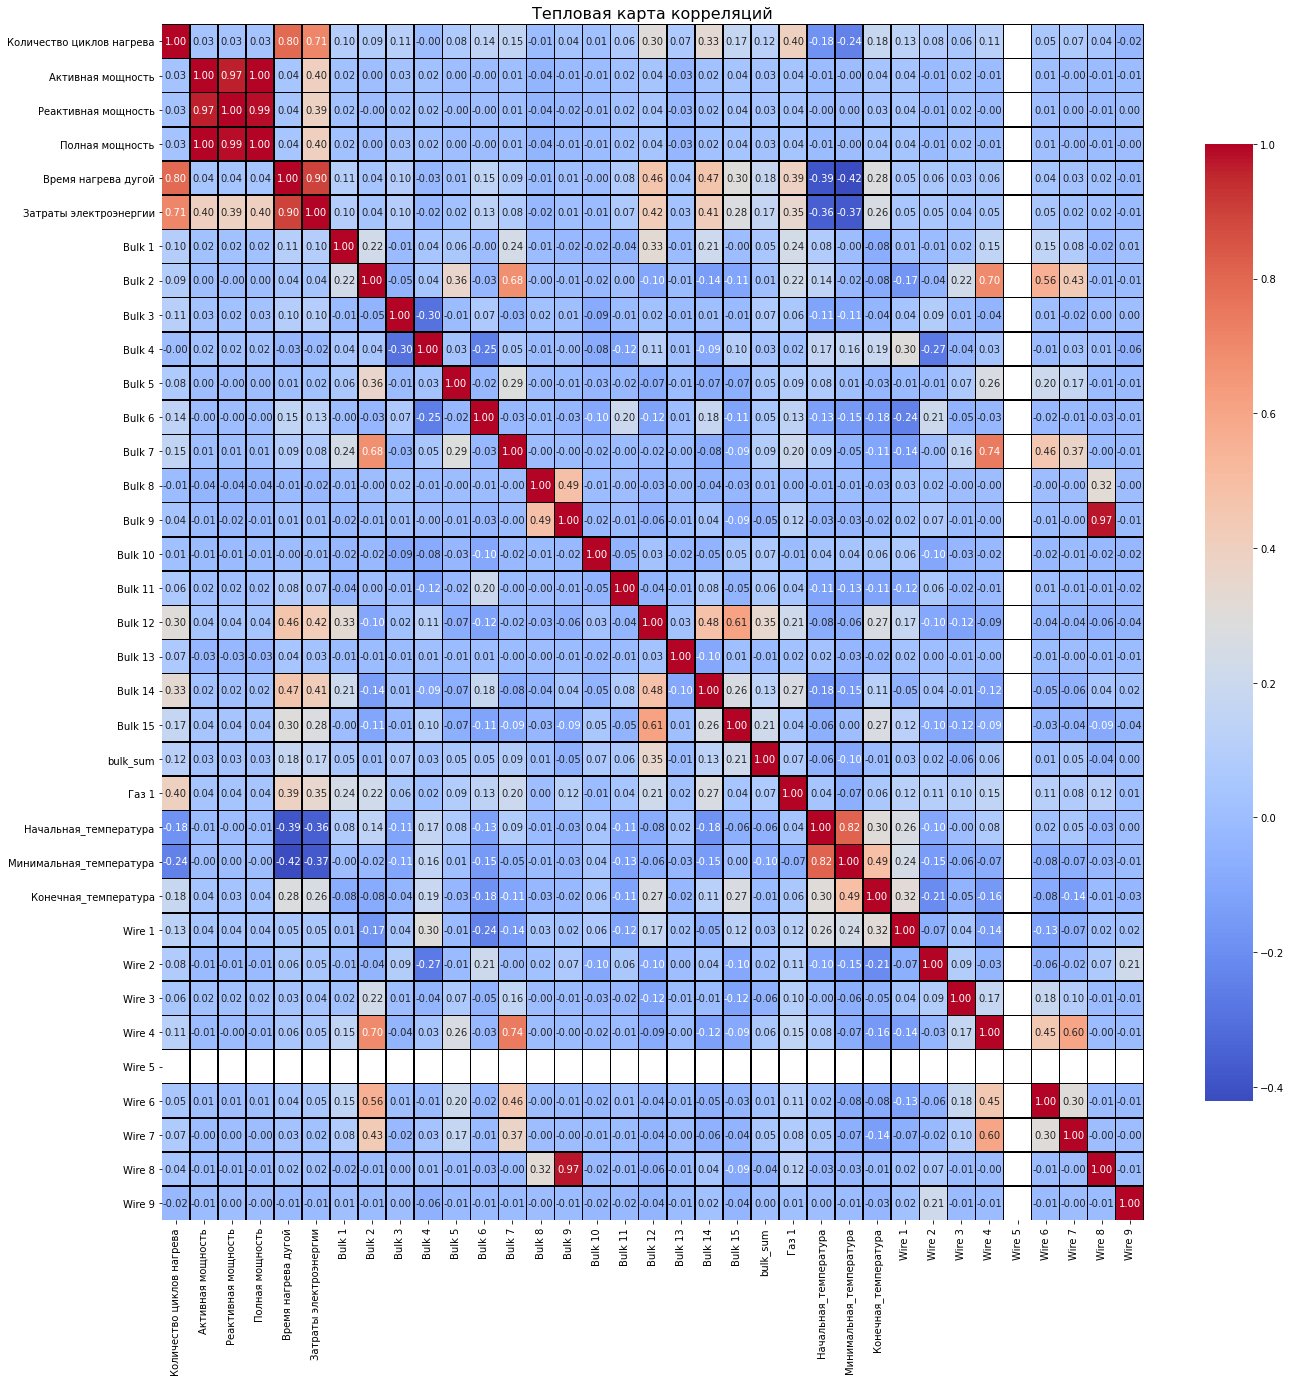

In [39]:
corr = merged_df.drop(columns=['key']).corr()

plt.figure(figsize=(22, 22))

# Построение тепловой карты
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='black')

plt.title('Тепловая карта корреляций', fontsize=16)

plt.show();

Видим что присутсвует мультиколлинеарность между признаками Bulk 9 и Wire 8, поэтому избавимся от признака Wire 8. Мультиколлинеарность также есть между такими признаками как Реактивная, Активная и Полная мощность, оставим только Реактивную мощность  

## Подготовка данных

In [41]:
X = merged_df.drop(columns=['Активная мощность', 
                            'Полная мощность', 
                            'Wire 8', 
                            'key', 
                            'Конечная_температура', 
#                           'Начальная_температура', 
                            'Начало нагрева дугой', 
                            'Конец нагрева дугой'])
y = merged_df['Конечная_температура']

X = X.drop('Минимальная_температура', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Разделили данные на тренировочную и тестовую выборку в соотношении 1 к 4, для дальнейшего обучения модели

In [42]:
X_train.head()

,Количество циклов нагрева,Реактивная мощность,Время нагрева дугой,Затраты электроэнергии,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Начальная_температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 9
668,4,0.499207,729,581.997132,0,0,0,214,0,0,...,10.511189,1604.0,81.291603,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
205,4,0.282849,420,225.642224,0,0,0,0,148,0,...,13.061285,1609.0,125.099525,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
807,6,0.595347,1286,1176.309828,90,0,0,0,0,0,...,22.806671,1591.0,185.561982,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2063,5,0.507503,633,496.002975,0,0,0,0,0,66,...,6.776783,1575.0,30.051840,100.282005,0.0,0.0,0.0,0.0,0.0,0.0
557,6,0.486633,1384,1190.168833,0,0,109,0,0,231,...,26.668457,1599.0,155.235611,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей машинного обучения

 **Определение метрик:**
- Определяются метрики для оценки моделей, возьмем коэффициент детерминации (R²) и среднюю абсолютную ошибку (MAE).

**Модели и гиперпараметры:** 
  - LinearRegression
  - RandomForestRegressor
  - GradientBoostingRegressor
  - CatBoostRegressor: Модель CatBoost, с настройками для количества итераций, скорости обучения и глубины деревьев.

**Создание и обучение моделей:**
- Для каждой модели создается пайплайн, состоящий из стандартизатора и самой модели. Затем используется GridSearchCV для подбора гиперпараметров с кросс-валидацией. Итоговые параметры и время обучения для каждой модели сохраняются.


In [43]:
# Определение метрик
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error)
}

# Определение моделей и гиперпараметров
models = {
    'LinearRegression': (LinearRegression(), {}),  
    'RandomForestRegressor': (RandomForestRegressor(random_state=42), {
        'randomforestregressor__n_estimators': [50, 100],
        'randomforestregressor__max_depth': [None, 10, 20]
    }),
    'GradientBoostingRegressor': (GradientBoostingRegressor(), {
        'gradientboostingregressor__n_estimators': [50, 100],
        'gradientboostingregressor__learning_rate': [0.01, 0.1]
    }),
    'CatBoostRegressor': (CatBoostRegressor(silent=True, random_state=42), {  
        'catboostregressor__iterations': [100, 200],
        'catboostregressor__learning_rate': [0.01, 0.1],
        'catboostregressor__depth': [6, 8]
    })
}

best_model = None
best_score = -np.inf
best_params = None
best_time = None

# Обучение моделей
for model_name, (model, param_grid) in models.items():
    start_time = time.time()
    
    # Создание пайплайна
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name.lower(), model)
    ])
    
    # Подбор гиперпараметров с помощью GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='R2', cv=5)
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    avg_r2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='r2', cv=5))
    avg_mae = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5))
    print('_'*100)
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Training Time: {elapsed_time:.2f} seconds")
    print(f"Cross-validated R2: {avg_r2:.4f}")
    print(f"Cross-validated MAE: {-avg_mae:.4f}\n")
    

    # Сравнение с лучшей моделью
    if avg_r2 > best_score:
        best_score = avg_r2
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_time = elapsed_time

# Вывод информации о лучшей модели
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best R2: {best_score:.4f}")
print(f"Best Training Time: {best_time:.2f} seconds")


____________________________________________________________________________________________________
Model: LinearRegression
Best Parameters: {}
Training Time: 0.97 seconds
Cross-validated R2: 0.3970
Cross-validated MAE: 6.2037

____________________________________________________________________________________________________
Model: RandomForestRegressor
Best Parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 100}
Training Time: 24.71 seconds
Cross-validated R2: 0.3966
Cross-validated MAE: 6.2227

____________________________________________________________________________________________________
Model: GradientBoostingRegressor
Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__n_estimators': 100}
Training Time: 7.00 seconds
Cross-validated R2: 0.4066
Cross-validated MAE: 6.1362

____________________________________________________________________________________________________
Model: CatBoostReg

Таким образом нашли лучшую модель, осталось проверить ее на тестовых данных

## Выбор лучшей модели

Проверка лучшей модели на тестовых данных

In [44]:
y_pred = best_model.predict(X_test)

r2_test = r2_score(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print(f" R2 CatBoostRegressor на тесте: {r2_test:.4f}")
print(f" MAE CatBoostRegressor на тесте: {mae_test:.4f}")

 R2 CatBoostRegressor на тесте: 0.4436
 MAE CatBoostRegressor на тесте: 6.4693


Посмотрим важность признаков с помощью графика:

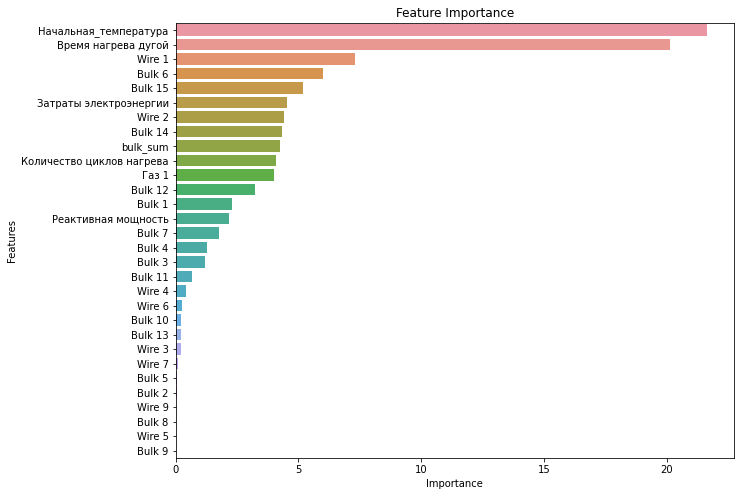

In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = CatBoostRegressor(depth=6, iterations=200, learning_rate=0.1, verbose=0)
model.fit(X_train, y_train)

feature_importances = model.get_feature_importance()
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Общий вывод и рекомендации заказчику

Мы успешно загрузили и обработали данные, устранив пропуски и выявив выбросы. Были добавлены новые признаки, такие как Количество циклов нагрева, Время нагрева дугой, Минимальная температура и Начальная температура. Признак Bulk sum общего объема добавленного сыпучего материала также был включен в набор данных.

В процессе подготовки данных, партии с начальной температурой ниже 1400°С, которые не соответствовали технологическому регламенту, были удалены.

Целевым признаком, согласно запросу заказчика, стала окончательная температура сплава. Мы провели корреляционный анализ с визуализацией, что позволило выявить 4 признака с сильной корреляцией. Для устранения мультиколлинеарности были удалены признаки реактивной и полной мощности, а также wire 8.

Данные были подготовлены и разделены на две выборки (train/test) в соотношении 75/25 для дальнейшего обучения моделей. Мы протестировали четыре различных модели: Линейная регрессия, Случайный лес, CatBoostRegressor и GradientBoostingRegressor. 

Наилучшие результаты продемонстрировала модель CatBoostRegressor с целевым показателем MAE=6.02 и R2=0.44 на тренировочных данных. Best Parameters: {'catboostregressor__depth': 6, 'catboostregressor__iterations': 200, 'catboostregressor__learning_rate': 0.1}.  
- R2 CatBoostRegressor на тесте: 0.44
- MAE CatBoostRegressor на тесте: 6.46133

Мы рекомендуем использовать обученную модель CatBoostRegressor с оптимизированными гиперпараметрами для прогнозирования температуры стали.